In [1]:
!pip install --upgrade pip

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
!pip install split-folders # from splitting dataset into train , test, val

In [3]:
# constants
IMAGE_SIZE= 256
CHANNELS=3
BATCH_SIZE=16 

# Split into Train Test and Validation Folders in ratio
* Training : 70%
* Testing : 20%
* Validation : 10%

In [4]:
Crops = { 
    'Potato' : {
        "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Potato',
        "WORKING_DIR" : './Potato_Dataset'
    }
    , 'Corn': {
        "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn',
        "WORKING_DIR" : './Corn_Dataset'
    },
    'Rice': {
        "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice',
        "WORKING_DIR" : './Rice_Dataset'
    },
    'Wheat': {
        "DATASET_DIR" : '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Wheat',
        "WORKING_DIR" : './Wheat_Dataset'
    }
}

In [5]:
import splitfolders , os

for crop in Crops.keys():
    if not (os.path.exists(Crops[crop]["WORKING_DIR"]) and os.path.isdir(Crops[crop]["WORKING_DIR"])):
        # Split the dataset into train, validation, and test sets
        splitfolders.ratio(Crops[crop]["DATASET_DIR"], output=Crops[crop]["WORKING_DIR"], seed=42, ratio=(0.8, 0.2))

Copying files: 2152 files [00:09, 236.13 files/s]
Copying files: 3852 files [00:13, 293.79 files/s]
Copying files: 4078 files [00:42, 95.75 files/s] 
Copying files: 2942 files [00:16, 183.76 files/s]


# Data Augmentation: 
ImageDataGenerator provides a wide range of built-in image data augmentation techniques, such as rotation, zooming, shearing, and flipping. This allows you to generate augmented images on-the-fly during training, which can help improve model generalization and performance.

* rotation_range=10,     # Randomly rotate images by up to 10 degrees
* width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of width
* height_shift_range=0.1,# Randomly shift images vertically by up to 10% of height
* shear_range=0.2,       # Shear intensity
* zoom_range=0.2,        # Zoom intensity
* horizontal_flip=True,  # Randomly flip images horizontally
* fill_mode='nearest'    # Fill pixels using the nearest value if augmented


In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen =  ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,         # Randomly rotate images up to 40 degrees
            width_shift_range=0.2,     # Randomly shift images horizontally by up to 20%
            height_shift_range=0.2,    # Randomly shift images vertically by up to 20%
            shear_range=0.2,           # Randomly apply shear transformations
            zoom_range=0.2,            # Randomly zoom in on images by up to 20%
            horizontal_flip=True,      # Randomly flip images horizontally
            fill_mode='nearest' 
    )


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:

for crop in Crops.keys():
    print('Crop : ' , crop)
    train_dir = Crops[crop]["WORKING_DIR"] +"/train"
    test_dir = Crops[crop]["WORKING_DIR"] +"/val"
    
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE , IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True  
        )
    
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE , IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',  
        shuffle=False  
        )
       
 
    Crops[crop]['train_generator']  = train_generator
    Crops[crop]['test_generator']  = test_generator    

Crop :  Potato
Found 1721 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Crop :  Corn
Found 3080 images belonging to 4 classes.
Found 772 images belonging to 4 classes.
Crop :  Rice
Found 3261 images belonging to 4 classes.
Found 817 images belonging to 4 classes.
Crop :  Wheat
Found 2352 images belonging to 3 classes.
Found 590 images belonging to 3 classes.


In [8]:
for crop in Crops.keys():
    disease_class = list(Crops[crop]["train_generator"].class_indices.keys())
    num_of_classes = len(disease_class)
    Crops[crop]["disease_class"] = disease_class
    Crops[crop]["num_of_classes"] = num_of_classes

In [9]:
for crop in Crops.keys():
    print(crop , Crops[crop]["disease_class"])
    

Potato ['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight']
Corn ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight']
Rice ['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']
Wheat ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


# visualizing

Visualizing Crop Disease :  Potato
Visualizing Crop Disease :  Corn
Visualizing Crop Disease :  Rice
Visualizing Crop Disease :  Wheat


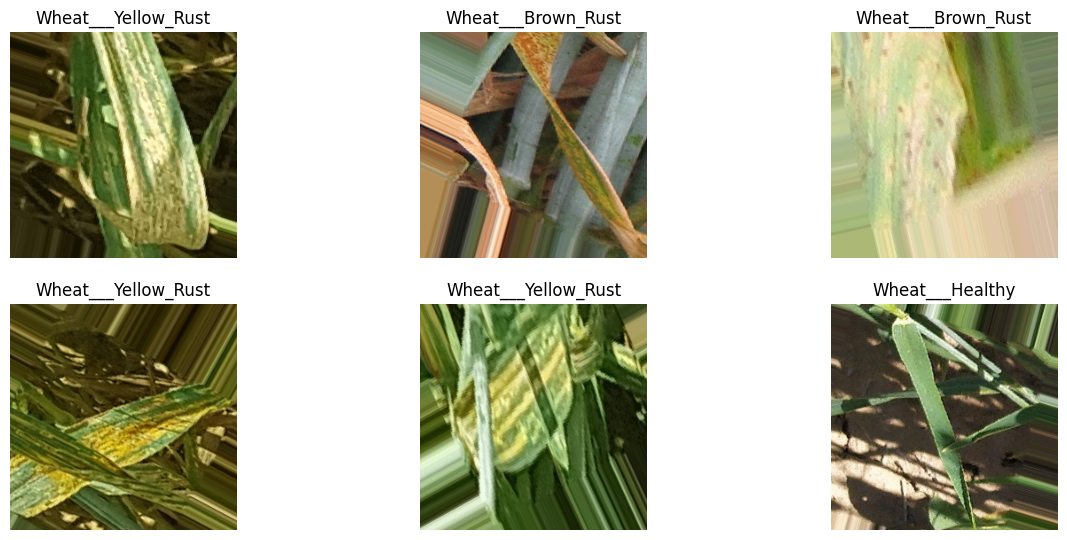

In [10]:
plt.figure( figsize= (15 , 10 ))


for crop in Crops.keys():
    print('Visualizing Crop Disease : ' , crop)
    
    num_images_to_display = 6
    for image_batch,label_batch in Crops[crop]["train_generator"] :
#         print(image_batch.shape , label_batch)

        for index in range(num_images_to_display):
            ax = plt.subplot( 3 , 3 , index + 1)
            
            plt.title(Crops[crop]["disease_class"] [ int(label_batch[index]) ] )
            
            plt.imshow(image_batch[index])
            plt.axis('off')
        break
        
plt.show()
    

# Traing Model using CNN 

In [11]:
!pip install seaborn

In [12]:
# Importing Deep learning modules
from  tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D , Dropout ,GlobalAveragePooling2D
from  tensorflow.keras import Sequential , Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy 
from  tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import confusion_matrix , classification_report 
import seaborn as sns


In [13]:
import tensorflow as tf

if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [14]:
tf.test.is_built_with_cuda()

True

In [15]:
EPOCHS =30

class Model_Build:
    def __init__(self  ,no_of_classes , train_generator , test_generator  ):
        self.model = None 
        self.model_history = None
        self.train_generator = train_generator
        self.test_generator = test_generator
        self.training_sets =train_generator.samples // train_generator.batch_size
        self.testing_sets =test_generator.samples // test_generator.batch_size
        self.no_of_classes = no_of_classes
        
        
        
    def model_create(self):
       
        self.model=  Sequential([
          
           Conv2D(filters = 32 , kernel_size = (3,3) , input_shape = (IMAGE_SIZE , IMAGE_SIZE , CHANNELS) , activation = 'relu'),
           MaxPooling2D( pool_size=(3, 3), strides=2, padding='same'),

           Conv2D(16, kernel_size=(2, 2),  activation='relu', padding='same'),
           MaxPooling2D( (2, 2), 2, padding='same'),

           Conv2D(8, kernel_size=(2, 2),  activation='relu', padding='same'),
           MaxPooling2D( (2, 2), 2, padding='same'),

           Flatten(),

           Dense(units = 128 , activation = 'relu'),
           Dense( self.no_of_classes , activation = 'softmax' ),
        ])
    
    def model_compile(self):   
        self.model.compile(
            optimizer = Adam(lr=0.0001),
            loss = SparseCategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        
    def model_summuary(self):
        if self.model:
            print(self.model.summary())
            
    def model_fit(self):     
        
        self.model_history = self.model.fit(
            self.train_generator,
            epochs=EPOCHS,
            validation_data=self.test_generator,
            steps_per_epoch=self.training_sets,
            validation_steps=self.testing_sets
            )
   
        return self.model_history
        
    def model_evaluate(self):
        score = self.model.evaluate(self.test_generator)
        print('Accuracy : ' , score[1])
        print('Loss : ' , score[0])
    
    def  model_predict(self , test):
        y_pred = self.model.predict(test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        return  y_pred_classes 
    
    
    def plot_accuracy_curve(self):
        plt.figure( figsize= (15 , 10 ))

        plt.subplot(2,2,1)
        plt.plot(range(EPOCHS) , self.model_history.history['accuracy']  , label='Training Accuracy')
        plt.plot(range(EPOCHS) , self.model_history.history['val_accuracy'] , label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')

        plt.subplot(2,2,2)
        plt.plot(range(EPOCHS) ,self.model_history.history['loss'] , label='Training Loss')
        plt.plot(range(EPOCHS) , self.model_history.history['val_loss'] , label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')

        plt.show()
        
    def show_classification_report(self , y_true , y_pred):
        print(classification_report(y_true , y_pred) )
        
    def show_confusion_matrix(self, y_true , y_pred):
        sns.heatmap(confusion_matrix(y_true , y_pred) , annot=True)
        plt.xlabel('Truth')
        plt.ylabel('Predicted')
        plt.show()
        
    def save_model(self,path):
        # Save model in h5 format so that there is just one file
        self.model.save(path)

# Create Potato Disease Model

In [16]:
Model = 'Potato'
potato = Model_Build(Crops['Potato']['num_of_classes'] ,  Crops['Potato']["train_generator"] ,Crops['Potato']["test_generator"])
potato.model_create()
potato.model_compile()
potato.model_fit()
potato.model_summuary()
potato.model_evaluate()

Epoch 1/30
107/107 [==============================] - 44s 329ms/step - loss: 0.7462 - accuracy: 0.6633 - val_loss: 0.5608 - val_accuracy: 0.7332
Epoch 2/30
107/107 [==============================] - 33s 309ms/step - loss: 0.4602 - accuracy: 0.8088 - val_loss: 0.2582 - val_accuracy: 0.8798
Epoch 3/30
107/107 [==============================] - 34s 314ms/step - loss: 0.3275 - accuracy: 0.8745 - val_loss: 0.5876 - val_accuracy: 0.7260
Epoch 4/30
107/107 [==============================] - 34s 314ms/step - loss: 0.3318 - accuracy: 0.8657 - val_loss: 0.2993 - val_accuracy: 0.8678
Epoch 5/30
107/107 [==============================] - 34s 315ms/step - loss: 0.2578 - accuracy: 0.9050 - val_loss: 0.1804 - val_accuracy: 0.9255
Epoch 6/30
107/107 [==============================] - 34s 315ms/step - loss: 0.2472 - accuracy: 0.8956 - val_loss: 0.2043 - val_accuracy: 0.9279
Epoch 7/30
107/107 [==============================] - 33s 307ms/step - loss: 0.2552 - accuracy: 0.9015 - val_loss: 0.1162 - val_ac

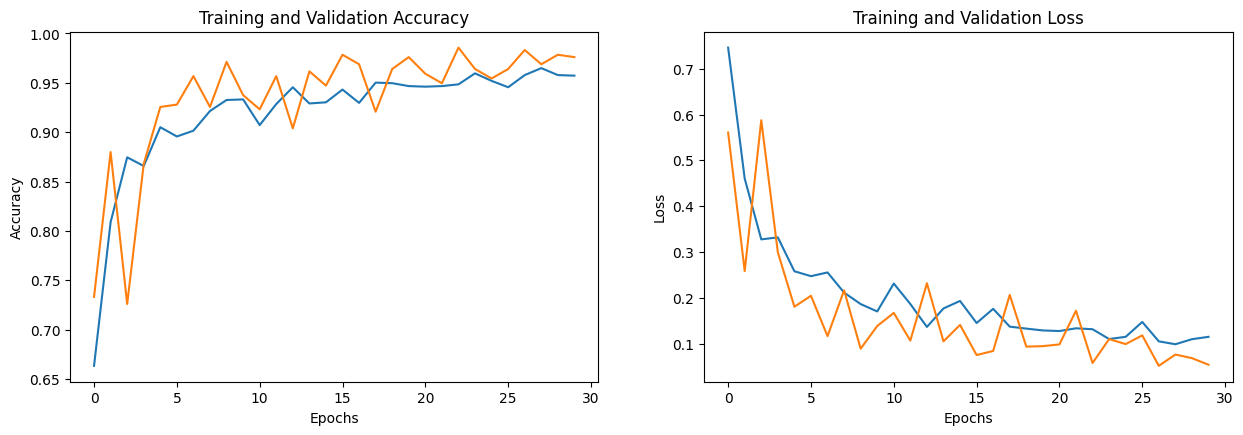

In [17]:
potato.plot_accuracy_curve()

In [18]:
y_pred = potato.model_predict(Crops['Potato']["test_generator"])

y_true = []
i = 0
for img , label in Crops['Potato']["test_generator"] :
    y_true.append( label.astype(int))
    if i >= potato.testing_sets:
        break
    i+= 1

y_true = np.concatenate(y_true, axis=0)
len(y_true) , len(y_pred)

27/27 [==============================] - 6s 207ms/step


(431, 431)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.91      1.00      0.95        31
           2       0.99      0.97      0.98       200

    accuracy                           0.98       431
   macro avg       0.96      0.99      0.98       431
weighted avg       0.98      0.98      0.98       431



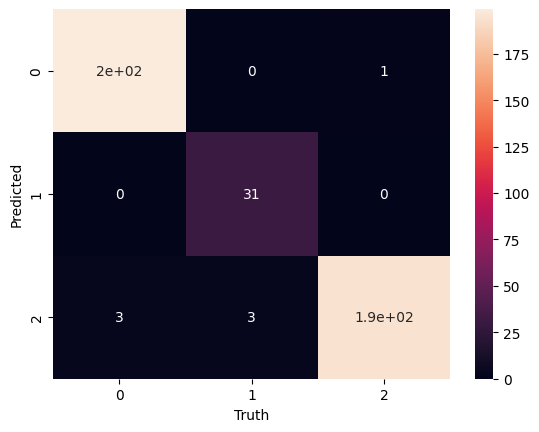

In [19]:
potato.show_classification_report(y_true , y_pred)

potato.show_confusion_matrix(y_true , y_pred)

In [20]:
potato.save_model('./saved_model/potato_disease_model.h5')

# Create Corn Disease Model

In [21]:
corn = Model_Build(Crops['Corn']['num_of_classes'], Crops['Corn']["train_generator"] , Crops['Corn']["test_generator"] )
corn.model_create()
corn.model_compile()
corn.model_fit()
corn.model_summuary()
corn.model_evaluate()

Epoch 1/30
192/192 [==============================] - 65s 331ms/step - loss: 0.5976 - accuracy: 0.7242 - val_loss: 0.3237 - val_accuracy: 0.8633
Epoch 2/30
192/192 [==============================] - 61s 320ms/step - loss: 0.3375 - accuracy: 0.8415 - val_loss: 0.2834 - val_accuracy: 0.8737
Epoch 3/30
192/192 [==============================] - 51s 268ms/step - loss: 0.3250 - accuracy: 0.8479 - val_loss: 0.4930 - val_accuracy: 0.7839
Epoch 4/30
192/192 [==============================] - 52s 272ms/step - loss: 0.2838 - accuracy: 0.8642 - val_loss: 0.2247 - val_accuracy: 0.9089
Epoch 5/30
192/192 [==============================] - 52s 268ms/step - loss: 0.2598 - accuracy: 0.8786 - val_loss: 0.2231 - val_accuracy: 0.8906
Epoch 6/30
192/192 [==============================] - 64s 333ms/step - loss: 0.2492 - accuracy: 0.8838 - val_loss: 0.2089 - val_accuracy: 0.9115
Epoch 7/30
192/192 [==============================] - 53s 277ms/step - loss: 0.2293 - accuracy: 0.8962 - val_loss: 0.1886 - val_ac

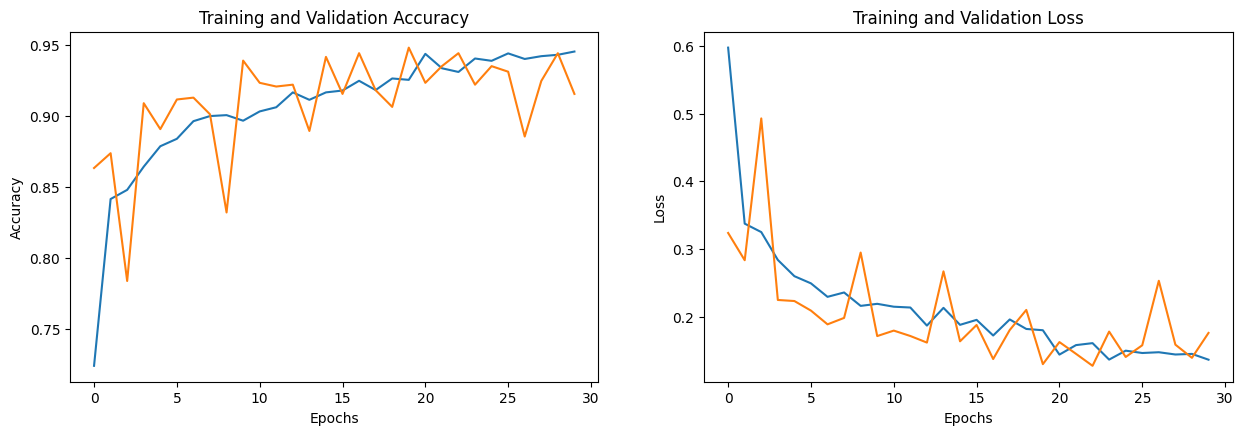

In [22]:
corn.plot_accuracy_curve()

In [23]:
y_pred = corn.model_predict(Crops['Corn']["test_generator"])

y_true = []
i = 0
for img , label in Crops['Corn']["test_generator"] :
    y_true.append( label.astype(int))
    if i >= corn.testing_sets:
        break
    i+= 1
    
y_true = np.concatenate(y_true, axis=0)
len(y_true)

49/49 [==============================] - 11s 219ms/step


772

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       0.98      0.45      0.61       103
           2       0.98      1.00      0.99       233
           3       0.79      0.99      0.88       197

    accuracy                           0.92       772
   macro avg       0.94      0.86      0.87       772
weighted avg       0.94      0.92      0.91       772



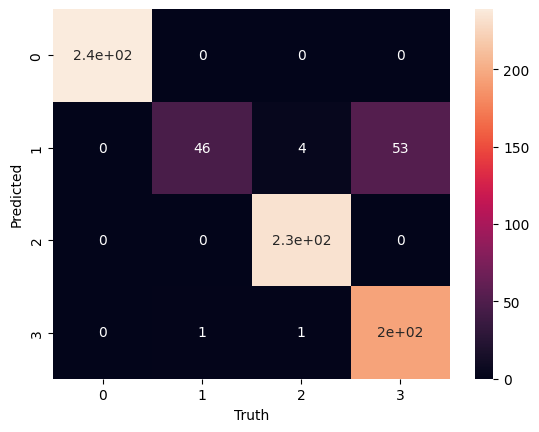

In [24]:
corn.show_classification_report(y_true , y_pred)

corn.show_confusion_matrix(y_true , y_pred)

In [25]:
corn.save_model('./saved_model/corn_disease_model.h5')

# Rice Model

In [26]:
Model_Name = 'Rice'
model = Model_Build(Crops[Model_Name]['num_of_classes'], Crops[Model_Name]["train_generator"] , Crops[Model_Name]["test_generator"] )
model.model_create()
model.model_compile()
model.model_fit()
model.model_summuary()
model.model_evaluate()

Epoch 1/30
203/203 [==============================] - 142s 691ms/step - loss: 0.9525 - accuracy: 0.5593 - val_loss: 0.7767 - val_accuracy: 0.6373
Epoch 2/30
203/203 [==============================] - 132s 652ms/step - loss: 0.7708 - accuracy: 0.6222 - val_loss: 0.7360 - val_accuracy: 0.6336
Epoch 3/30
203/203 [==============================] - 141s 694ms/step - loss: 0.7919 - accuracy: 0.6225 - val_loss: 0.7537 - val_accuracy: 0.6605
Epoch 4/30
203/203 [==============================] - 125s 619ms/step - loss: 0.7649 - accuracy: 0.6333 - val_loss: 0.7345 - val_accuracy: 0.6654
Epoch 5/30
203/203 [==============================] - 132s 649ms/step - loss: 0.7617 - accuracy: 0.6357 - val_loss: 0.7390 - val_accuracy: 0.6348
Epoch 6/30
203/203 [==============================] - 118s 580ms/step - loss: 0.7344 - accuracy: 0.6410 - val_loss: 0.7016 - val_accuracy: 0.6654
Epoch 7/30
203/203 [==============================] - 123s 606ms/step - loss: 0.7338 - accuracy: 0.6576 - val_loss: 0.7111 -

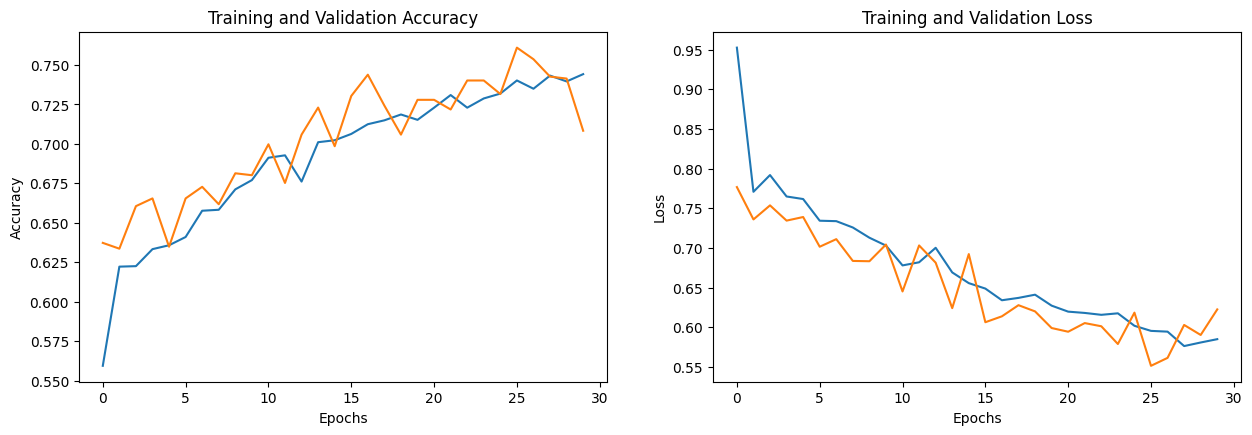

In [27]:
model.plot_accuracy_curve()

In [34]:
model.save_model('./saved_model/rice_disease_model.h5')

# Wheat Model

In [29]:
Model_Name = 'Wheat'
model = Model_Build(Crops[Model_Name]['num_of_classes'], Crops[Model_Name]["train_generator"] , Crops[Model_Name]["test_generator"] )
model.model_create()
model.model_compile()
model.model_fit()
model.model_summuary()
model.model_evaluate()

Epoch 1/30
147/147 [==============================] - 49s 322ms/step - loss: 0.6791 - accuracy: 0.6747 - val_loss: 0.3610 - val_accuracy: 0.8611
Epoch 2/30
147/147 [==============================] - 46s 315ms/step - loss: 0.3659 - accuracy: 0.8571 - val_loss: 0.2917 - val_accuracy: 0.8924
Epoch 3/30
147/147 [==============================] - 47s 320ms/step - loss: 0.3053 - accuracy: 0.8848 - val_loss: 0.2381 - val_accuracy: 0.9167
Epoch 4/30
147/147 [==============================] - 46s 314ms/step - loss: 0.2716 - accuracy: 0.9001 - val_loss: 0.2457 - val_accuracy: 0.8872
Epoch 5/30
147/147 [==============================] - 47s 318ms/step - loss: 0.2216 - accuracy: 0.9162 - val_loss: 0.1482 - val_accuracy: 0.9427
Epoch 6/30
147/147 [==============================] - 46s 316ms/step - loss: 0.1954 - accuracy: 0.9294 - val_loss: 0.1659 - val_accuracy: 0.9427
Epoch 7/30
147/147 [==============================] - 47s 321ms/step - loss: 0.1819 - accuracy: 0.9362 - val_loss: 0.1393 - val_ac

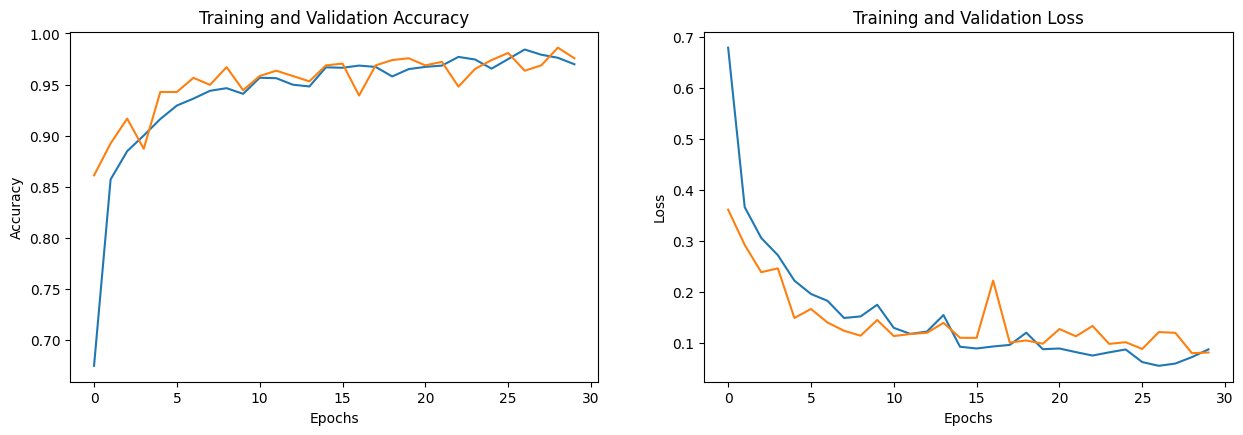

In [30]:
model.plot_accuracy_curve()

In [35]:
model.save_model('./saved_model/wheat_disease_model.h5')

# Save Crop disease mapping

In [32]:
import json

data = {  }

for crop in Crops.keys():
    print('--- Saved ' , crop , ' Model---' )
    data[crop + '_disease'] =  Crops[crop]['disease_class']
    
with open('./crop_disease_mapping.json', 'w') as json_file:
    json.dump( data, json_file)

--- Saved  Potato  Model---
--- Saved  Corn  Model---
--- Saved  Rice  Model---
--- Saved  Wheat  Model---


# load the model


In [36]:
from tensorflow.keras.models import  load_model 
# Load the saved model
corn_model = load_model('/kaggle/working/saved_model/corn_disease_model.h5')

In [37]:
with open("/kaggle/working/crop_disease_mapping.json", 'r') as json_file:
    disease_class_mapping = json.load(json_file)
print(disease_class_mapping)

{'Potato_disease': ['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight'], 'Corn_disease': ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight'], 'Rice_disease': ['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast'], 'Wheat_disease': ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']}


In [40]:
from tensorflow.keras.preprocessing import image

# img_path = "/kaggle/working/Potato_Dataset/val/Potato___Late_Blight/86323439-ca8d-4819-ae81-800e50f85770___RS_LB 2826.JPG"
# img_path = "/kaggle/working/Potato_Dataset/val/Potato___Early_Blight/a3fe02f0-6d49-4e9a-ba9a-ac26e8b65ca9___RS_Early.B 7560.JPG"
img_path = "/kaggle/working/Corn_Dataset/val/Corn___Gray_Leaf_Spot/image (481).jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array/255



In [41]:
# Make predictions
predicted_class_index = np.argmax(corn_model.predict(img_array) , axis=1)[0]
predicted_class_index
predicted_class = disease_class_mapping['Corn_disease'][predicted_class_index]

print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 72ms/step
Predicted Class: Corn___Northern_Leaf_Blight
